## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [2]:
from torch_geometric.datasets import Twitch

dataset = Twitch(root="/tmp/ES", name="ES")
data = dataset[0]

num_samples = data.num_nodes
train_mask = torch.zeros(num_samples, dtype=torch.bool)
val_mask = torch.zeros(num_samples, dtype=torch.bool)
test_mask = torch.zeros(num_samples, dtype=torch.bool)

train_mask[:int(0.8 * num_samples)] = 1
val_mask[int(0.8 * num_samples):int(0.9 * num_samples)] = 1
test_mask[int(0.9 * num_samples):] = 1

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

## Statistical Modeling ##

In [3]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [5]:
pd_data.shape

(4648, 128)

In [6]:
pd_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.000000,-0.016866,-0.016156,-0.017455,-0.009328,0.009001,-0.001389,-0.018863,-0.007887,-0.015034,...,0.020451,0.005076,0.029050,-0.010025,0.006484,0.017001,-0.014674,0.011937,-0.010455,0.008883
1,-0.016866,1.000000,0.012467,-0.025874,-0.014683,0.033612,0.003099,0.088013,-0.009469,0.066133,...,0.013903,-0.009666,0.003455,0.025094,-0.002294,-0.012417,0.034463,0.007706,-0.015849,-0.018553
2,-0.016156,0.012467,1.000000,-0.010504,0.033319,0.000714,-0.003699,0.037657,-0.017298,0.104026,...,-0.005988,-0.014338,0.025665,0.009927,-0.009025,-0.023361,0.017052,-0.009850,-0.009111,-0.006457
3,-0.017455,-0.025874,-0.010504,1.000000,0.064956,-0.000843,-0.014434,-0.025177,0.029445,-0.018777,...,-0.012224,-0.022719,-0.003916,-0.011551,0.031508,-0.010132,-0.014610,-0.009039,-0.015040,-0.004724
4,-0.009328,-0.014683,0.033319,0.064956,1.000000,-0.008157,-0.032593,0.009087,0.016828,0.016163,...,-0.011291,-0.021182,-0.006367,0.009492,0.010815,0.029311,0.018405,-0.023003,-0.004562,0.021185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.017001,-0.012417,-0.023361,-0.010132,0.029311,0.000311,0.004367,0.009924,0.007036,-0.007553,...,0.030636,0.009781,-0.047601,-0.003229,0.008574,1.000000,-0.013552,-0.005122,-0.053676,-0.009121
124,-0.014674,0.034463,0.017052,-0.014610,0.018405,0.033998,-0.033041,-0.017252,-0.016826,0.015254,...,0.035242,-0.034176,0.007124,0.026943,-0.009205,-0.013552,1.000000,0.025410,0.015357,0.035436
125,0.011937,0.007706,-0.009850,-0.009039,-0.023003,0.026246,-0.216930,0.039435,-0.007699,0.014748,...,0.014799,-0.114496,-0.004519,0.005889,0.007425,-0.005122,0.025410,1.000000,-0.020645,-0.001025
126,-0.010455,-0.015849,-0.009111,-0.015040,-0.004562,-0.002123,0.015060,-0.017875,0.007201,0.000801,...,-0.014728,-0.003160,0.332039,0.008686,0.006217,-0.053676,0.015357,-0.020645,1.000000,0.021127


In [11]:
pd_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,...,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000,4648.000000
mean,-0.145441,-0.020372,-0.040622,-0.188192,-0.045400,-0.032142,0.007975,0.050361,-0.037902,-0.030928,...,-0.091696,0.106191,0.007150,-0.061317,-0.019559,0.051177,-0.037933,0.001055,-0.038592,-0.057455
std,0.582505,0.958091,0.865017,0.131363,0.868439,0.913923,1.009488,1.048415,0.870321,0.940637,...,0.490445,1.187969,1.016017,0.934349,0.945880,1.138235,0.954983,0.985198,0.924352,0.830754
min,-0.236669,-0.230716,-0.160547,-0.217247,-0.212379,-0.203848,-0.538649,-0.411488,-0.162248,-0.223381,...,-0.127517,-0.239307,-0.214107,-0.355245,-0.175422,-0.213861,-0.375776,-0.634779,-0.255846,-0.183876
25%,-0.236669,-0.230716,-0.160547,-0.217247,-0.212379,-0.203848,-0.538649,-0.411488,-0.162248,-0.223381,...,-0.127517,-0.239307,-0.214107,-0.355245,-0.175422,-0.213861,-0.375776,-0.634779,-0.255846,-0.183876
50%,-0.236669,-0.230716,-0.160547,-0.217247,-0.212379,-0.203848,-0.538649,-0.411488,-0.162248,-0.223381,...,-0.127517,-0.239307,-0.214107,-0.355245,-0.175422,-0.213861,-0.375776,-0.634779,-0.255846,-0.183876
75%,-0.212834,-0.230716,-0.160547,-0.217247,-0.199442,-0.203848,-0.238398,-0.408430,-0.162248,-0.223381,...,-0.127517,-0.225388,-0.211525,-0.355245,-0.175422,-0.200585,-0.375776,1.260176,-0.255694,-0.183869
max,5.732687,5.309744,7.441195,1.213803,5.335903,5.933422,4.047821,2.601916,6.526685,8.334117,...,9.007938,8.579137,5.295609,3.403292,5.937289,6.539473,2.717424,3.483302,4.579420,5.799938


In [74]:
def data_to_nx_subgraph(data):
    G = nx.Graph()

    G.add_nodes_from(range(int(data.num_nodes/100)))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    G.add_edges_from(edges)

    return G

G = data_to_nx_subgraph(data)

In [76]:
nx.cluster.average_clustering(G)

0.2224963259246414

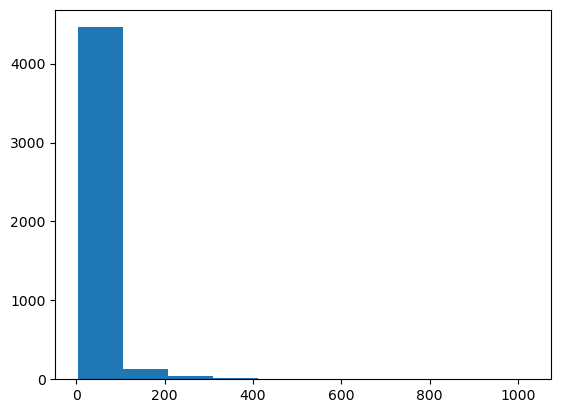

In [78]:
plt.hist([v for k, v in nx.degree(G)]);

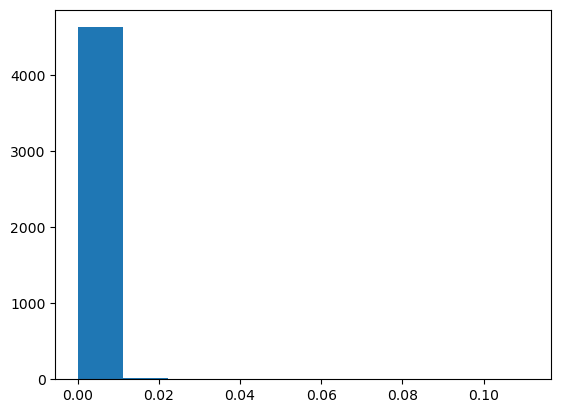

In [80]:
plt.hist(nx.centrality.betweenness_centrality(G).values());

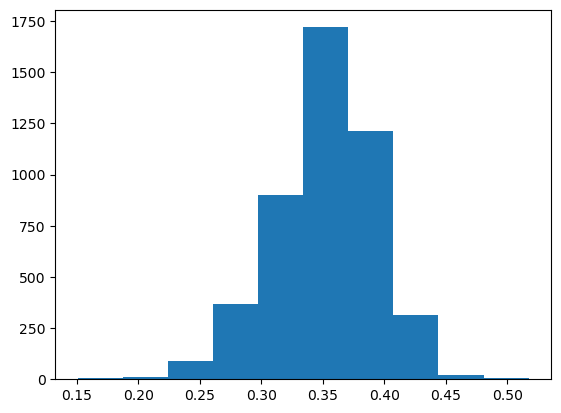

In [81]:
plt.hist(nx.centrality.closeness_centrality(G).values());

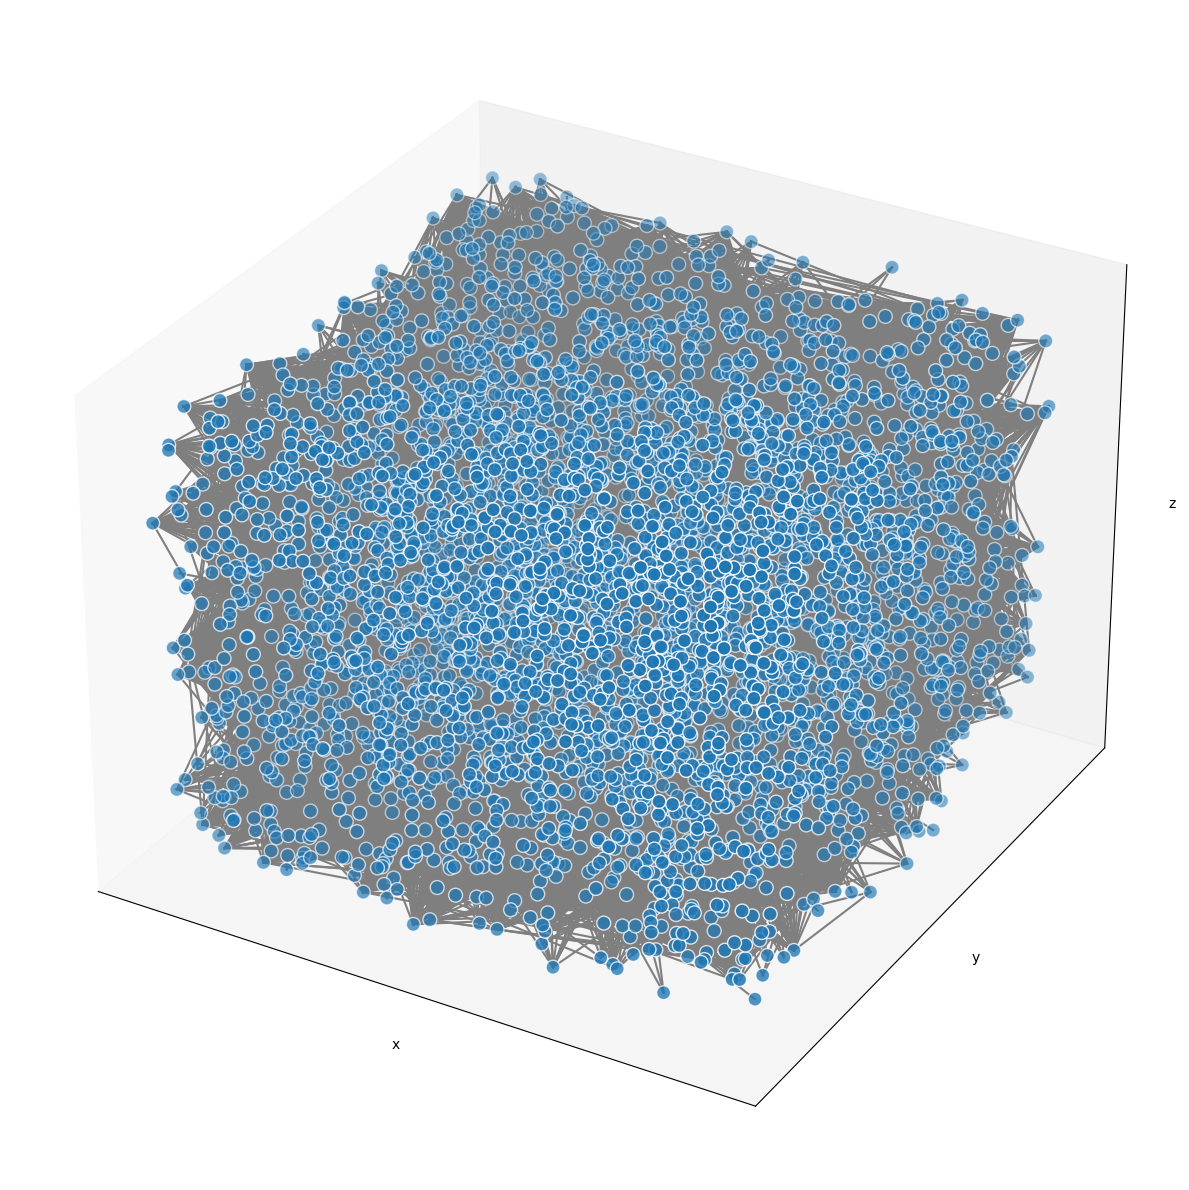

In [136]:
pos = nx.random_layout(G, dim=3, seed=779)

node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(*node_xyz.T, s=100, ec="w")

for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    ax.grid(False)

    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

## Training Model ##

In [234]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        return x

In [236]:
LR = 1e-04
HIDDEN = 32
EPOCHS = 400

In [238]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [240]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           32
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       4,096
├─GCNConv: 1-2                           32
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       1,024
├─GCNConv: 1-3                           2
│    └─SumAggregation: 2-5               --
│    └─Linear: 2-6                       64
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0

In [242]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [244]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 0.7343, Test Accuracy: 0.2796
Epoch: 10, Loss: 0.7175, Test Accuracy: 0.3118
Epoch: 20, Loss: 0.7032, Test Accuracy: 0.4043
Epoch: 30, Loss: 0.6915, Test Accuracy: 0.5699
Epoch: 40, Loss: 0.6820, Test Accuracy: 0.6409
Epoch: 50, Loss: 0.6745, Test Accuracy: 0.6667
Epoch: 60, Loss: 0.6686, Test Accuracy: 0.6753
Epoch: 70, Loss: 0.6639, Test Accuracy: 0.6925
Epoch: 80, Loss: 0.6602, Test Accuracy: 0.7118
Epoch: 90, Loss: 0.6572, Test Accuracy: 0.7161
Epoch: 100, Loss: 0.6546, Test Accuracy: 0.7183
Epoch: 110, Loss: 0.6524, Test Accuracy: 0.7290
Epoch: 120, Loss: 0.6504, Test Accuracy: 0.7312
Epoch: 130, Loss: 0.6486, Test Accuracy: 0.7333
Epoch: 140, Loss: 0.6468, Test Accuracy: 0.7312
Epoch: 150, Loss: 0.6452, Test Accuracy: 0.7312
Epoch: 160, Loss: 0.6435, Test Accuracy: 0.7333
Epoch: 170, Loss: 0.6419, Test Accuracy: 0.7333
Epoch: 180, Loss: 0.6403, Test Accuracy: 0.7333
Epoch: 190, Loss: 0.6387, Test Accuracy: 0.7355
Epoch: 200, Loss: 0.6371, Test Accuracy: 0.7355
Epo

## Post-Training Analysis ##

In [246]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

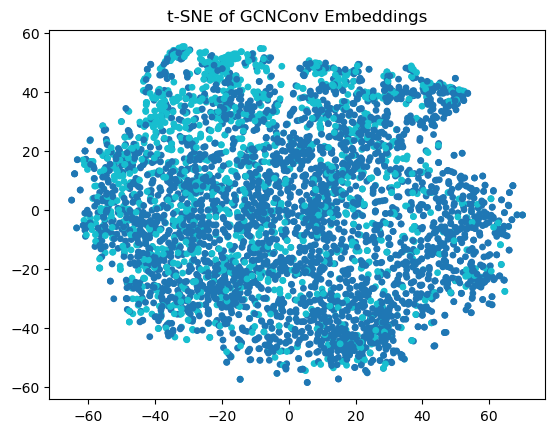

In [248]:
z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [249]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

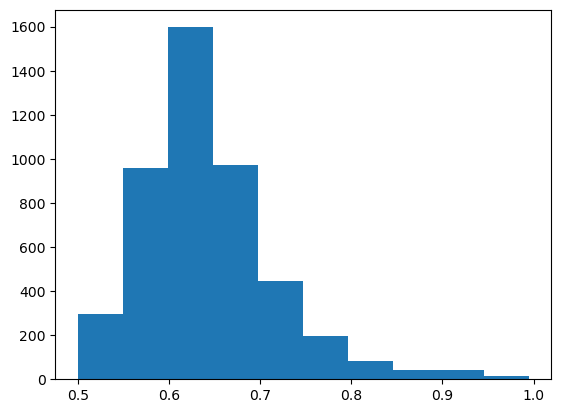

In [250]:
plt.hist(confidence.detach().numpy())
plt.show()

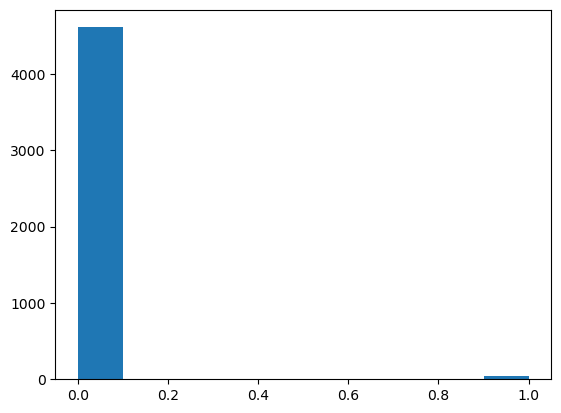

In [251]:
plt.hist(pred_class)
plt.show()

In [252]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 1350


In [258]:
torch.save(model.state_dict(), "Twitch.pth")

In [260]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("Twitch.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(128, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 2)
)